In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import geopandas as gpd

In [2]:
path_catalog = "../../Bases_de_datos/Data_catalog.csv"
path_v = "../data/variables.csv"
map_d = "../../Bases_de_datos/Mapas/"
data_d = "../results/"
map_f = [ "Natural_Earth/ne_50m_admin_0_countries",
    "Natural_Earth/ne_10m_admin_1_states_provinces",
    "OECD/OECD_TL2_shapefile",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_RUSSIA_CHINA_INDIA.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_BRAZIL.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_COLOMBIA.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_PERU.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_SOUTH_AFRICA.shp" ]
data_f = [ "Deciles_Climatico.csv", "Deciles_Gobernanza.csv",
    "Deciles_Socioeconomico.csv", "resumen_categorias.csv",
    "Valores_Climatico.csv", "Valores_Gobernanza.csv",
    "Valores_Socioeconomico.csv" ]

ix  = "alpha-3"
ix1 = "fips" 

df_c = pd.read_csv(path_catalog)
df_v = pd.read_csv(path_v)

gdf0 = gpd.read_file( map_d + map_f[0] ).rename(
    columns = {"GU_A3": ix} ).set_index( ix )
gdf1 = gpd.read_file( map_d + map_f[1] ).set_index( ix1 )

df_1   = pd.read_csv( data_d + data_f[3], index_col = ix )
df_2 = pd.read_csv( data_d + data_f[0], index_col = ix )
df_3 = pd.read_csv( data_d + data_f[4], index_col = ix )

gdf_2 = gdf0.merge(df_1, how = "left",
    left_index = True, right_index = True )
gdf_3 = gdf_2.merge( df_2, how = "left",
    left_index = True, right_index = True )
gdf_4 = gdf_2.merge( df_3, how = "left",
    left_index = True, right_index = True )

df_3.columns

Index(['HD_POP_EXP', 'HD_TN_POP_EXP', 'ID_POP_EXP', 'UTCI_POP_EXP',
       'TEMP_CHANGE', 'CF_BUILT_EXP', 'CF_POP_EXP', 'CF_CROP_EXP',
       'ED_CROP_ANOM', '99PT_LAND_EXP', 'EP_CHANGE', '99PT_CROP_EXP',
       'RF_BUILT_EXP', 'RF_POP_EXP', 'RF_CROP_EXP', 'BURN_LAND_AREA',
       'FT_POP_EXP', 'FT_FORE_EXP', 'CY_BUILT_EXP', 'CY_POP_EXP',
       'W_BUILT_EXP', 'W_POP_EXP', 'MEAN_POP', 'POP_EXP_POL', 'EP_LAND_EXP'],
      dtype='object')

In [3]:
gdf_oe = gpd.read_file(map_d + map_f[2] ).rename(
    columns = {"iso3": ix, "tl2_id": "REF_AREA", "name_en": "NAME"}
    ).set_index("REF_AREA")[ [ix, "NAME", "geometry"] ]
gdf_noe = []
for f in map_f[3:]:
    gdf_noe.append( gpd.read_file(map_d + f).to_crs(4326))
gdf_noe[0] = gdf_noe[0].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[1] = gdf_noe[1].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")

gdf_noe[3] = gdf_noe[3].rename( columns = {"TL_CODE": "REF_AREA",
    "TL_NAME": "NAME", "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[4] = gdf_noe[4].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe = pd.concat( gdf_noe[0:2] + gdf_noe[3:] )[
    [ix, "NAME", "geometry"] ]

gdf_oecd = pd.concat( [gdf_oe, gdf_noe] )

gdf_countries = gdf0.loc[ ~gdf0.index.isin(gdf_oecd[ix].unique()),
    ["NAME", "geometry"] ]
gdf_countries.index = gdf_countries.index.rename("REF_AREA")
gdf_countries[ix] = gdf_countries.index
gdf_oecd = pd.concat( [gdf_oecd, gdf_countries] )

In [12]:
id = "EXT_TEMP"
v = "HD_POP_EXP"
dur = df_v.loc[df_v["Variable"] == v , "DURATION"].iloc[0]

df = pd.read_csv( "../../" + df_c.loc[df_c["ID"] == id, "Path"].iloc[0]
    + df_c.loc[df_c["ID"] == id, "Filename"].iloc[0])

df_i = df[ (df["MEASURE"] == v) & (df["DURATION"] == dur) ]
df_i = df_i.sort_values( ["REF_AREA", "TIME_PERIOD"]
    ).drop_duplicates("REF_AREA", keep = "last").set_index("REF_AREA")

gdf_sub = gdf_oecd.merge(df_i, how = "left",
    left_index = True, right_index = True )

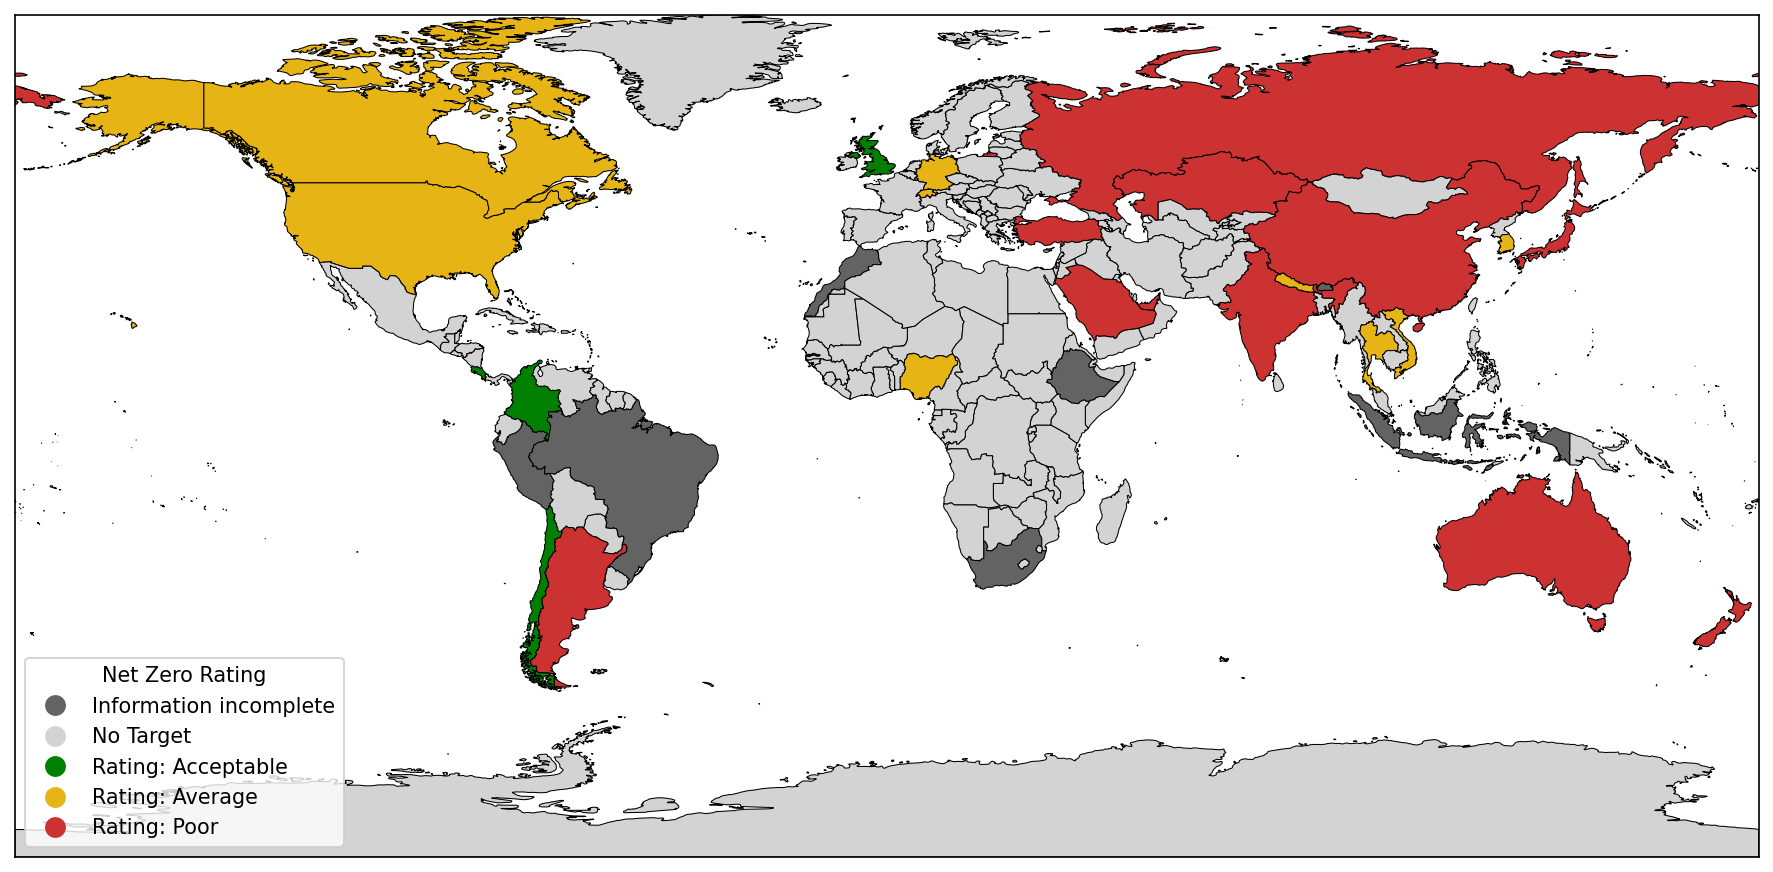

In [245]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(15, 10)
fig.set_dpi(150) 

gdf_2["Net Zero Rating"] = gdf_2["Net Zero Rating"].fillna( "No Target"
    ).replace( { "Acceptable": "Rating: Acceptable",
    "Average": "Rating: Average", "Poor": "Rating: Poor" } )

color_dict = { "Information incomplete": "#636363", "No Target": "lightgrey",
    "Rating: Acceptable": "green", "Rating: Average": "#e7b416",
    "Rating: Poor": "#cc3232", 
  }

gdf_2.plot( ax = ax, column = gdf_2["Net Zero Rating"],
    cmap = colors.ListedColormap(list(color_dict.values())),
    edgecolor = "black", linewidth = 0.5, legend = True,
    legend_kwds = {"title": "Net Zero Rating", "loc": "lower left"} ) 

#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

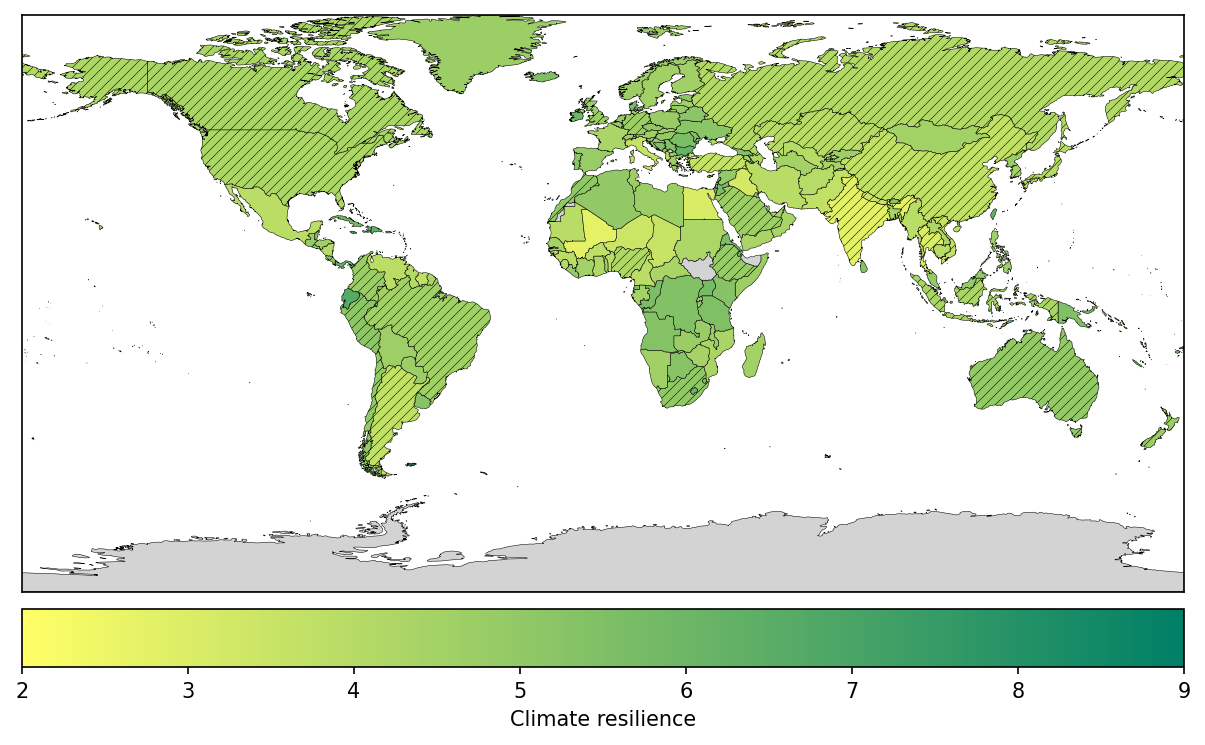

In [246]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

plt.rcParams["hatch.linewidth"] = 0.25

gdf_3.plot( ax = ax, column = "Mean",  edgecolor = "black", linewidth = 0.25,
    cmap = "summer_r", legend = True,
    vmin = np.floor( gdf_3["Mean"].min() ),
    vmax = np.ceil( gdf_3["Mean"].max() ),
    legend_kwds = {"label": "Climate resilience",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

gdf_3[ ~gdf_3["Net Zero Rating"].isnull() ].plot( ax = ax,
    edgecolor = "black", color = "none",
    hatch = "/////", linewidth = 0 )

#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

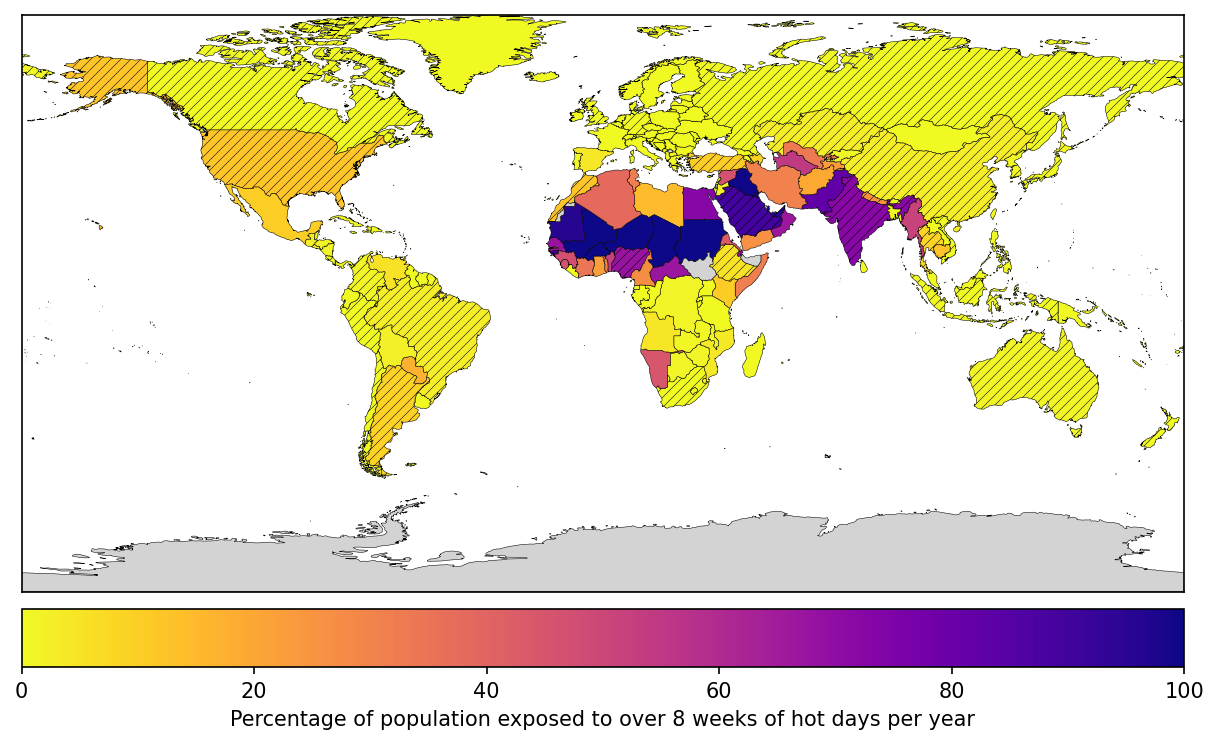

In [276]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

plt.rcParams["hatch.linewidth"] = 0.25

name = "Percentage of population exposed to over 8 weeks of hot days per year"
v = "HD_POP_EXP"

gdf_4.plot( ax = ax, column = v,  edgecolor = "black", linewidth = 0.25,
    cmap = "plasma_r", legend = True,
    vmin = np.floor( gdf_4[v].min() ), vmax = np.ceil( gdf_4[v].max() ),
    legend_kwds = {"label": name,
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

gdf_4[ ~gdf_4["Net Zero Rating"].isnull() ].plot( ax = ax,
    edgecolor = "black", color = "none",
    hatch = "/////", linewidth = 0 )

#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

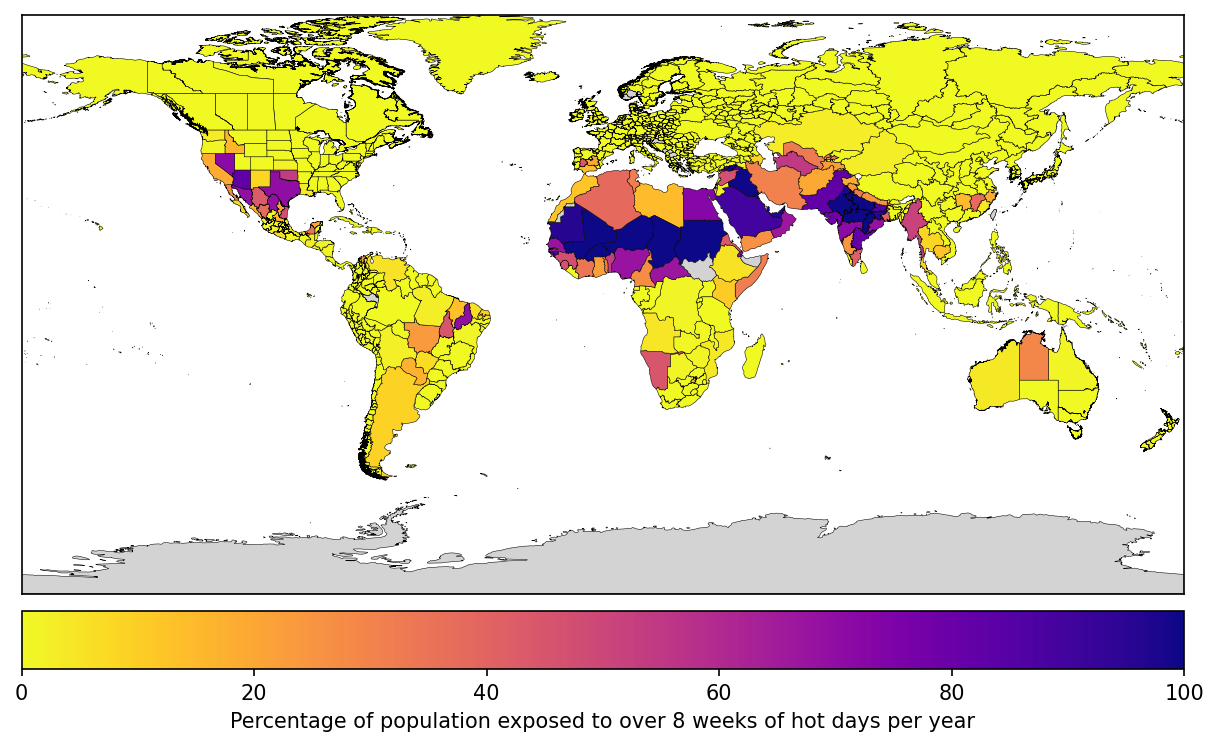

In [14]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

plt.rcParams["hatch.linewidth"] = 0.25

name = "Percentage of population exposed to over 8 weeks of hot days per year"
v = "OBS_VALUE"

gdf_sub.plot( ax = ax, column = v,  edgecolor = "black", linewidth = 0.25,
    cmap = "plasma_r", legend = True,
    vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {"label": name,
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

#gdf_4[ ~gdf_4["Net Zero Rating"].isnull() ].plot( ax = ax,
#    edgecolor = "black", color = "none",
#    hatch = "/////", linewidth = 0 )

#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()